<ipython-input-23-50336cd82261>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = filtered_data['Total Sales'].resample('M').sum()


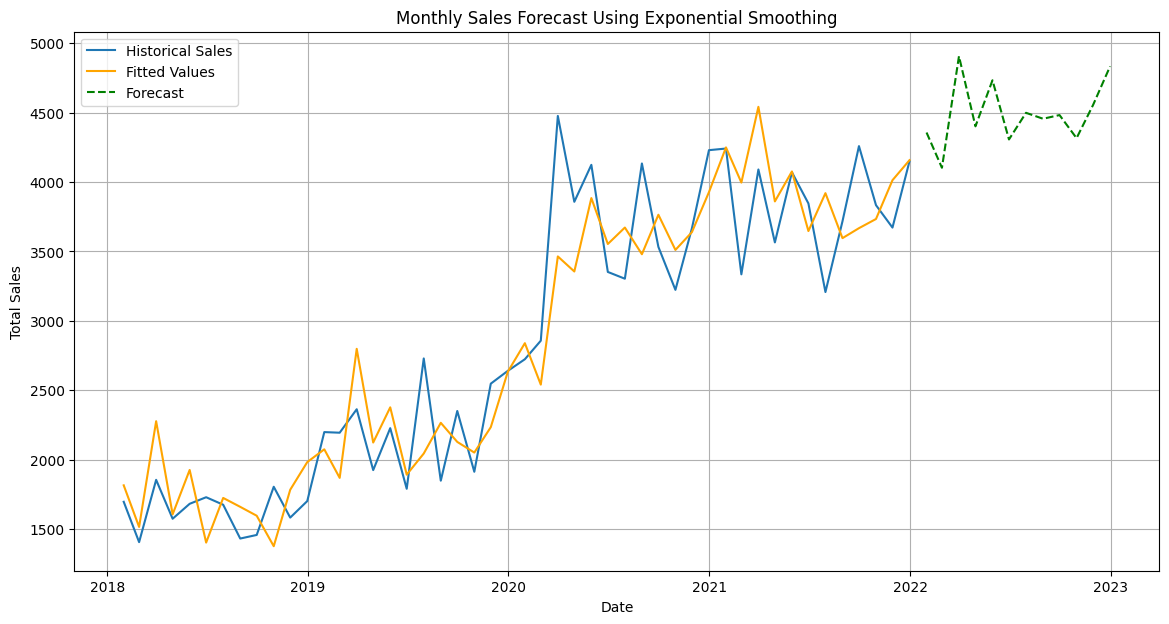

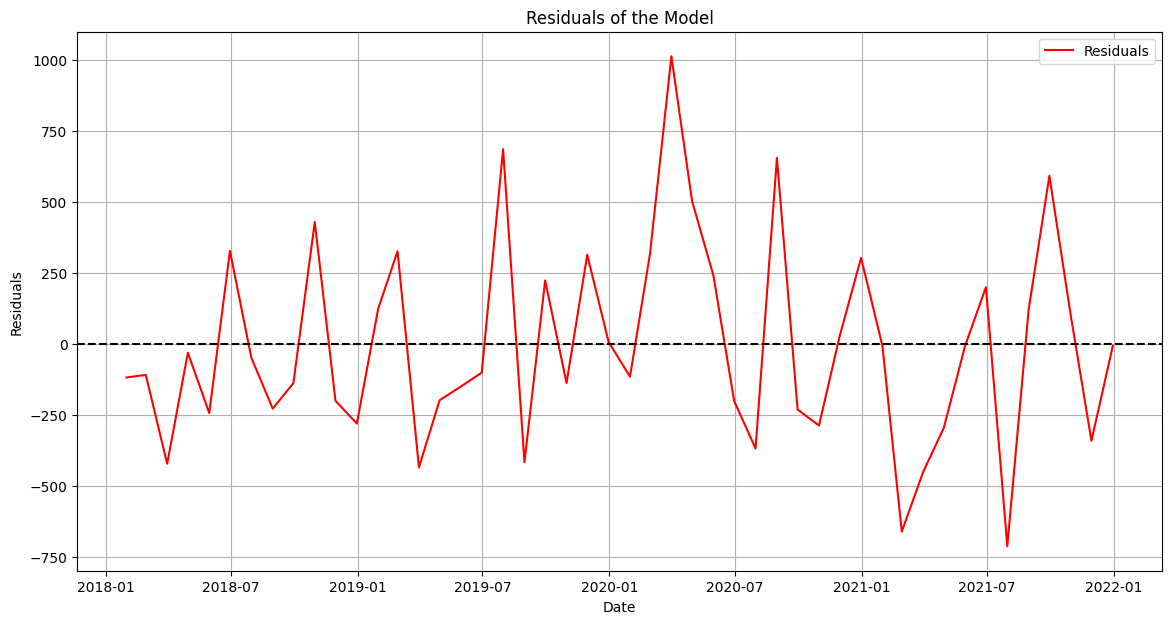

(count      48.000000
 mean       -9.487990
 std       356.929343
 min      -712.827364
 25%      -234.795778
 50%       -75.359284
 75%       227.067063
 max      1012.447806
 dtype: float64,
 2022-01-31    4357.036122
 2022-02-28    4103.143238
 2022-03-31    4906.965089
 2022-04-30    4401.588739
 2022-05-31    4733.688275
 2022-06-30    4307.109250
 2022-07-31    4499.166703
 2022-08-31    4456.286408
 2022-09-30    4482.822458
 2022-10-31    4316.365196
 2022-11-30    4555.231551
 2022-12-31    4834.020291
 Freq: ME, dtype: float64)

In [23]:
# Attempting to load and process the dataset from the new location URL provided
file_url = 'https://raw.githubusercontent.com/clionmuhoza/Business_Forecasting_Project/refs/heads/main/Filtered_combined_dataset_until_2022.csv'

# Load the dataset from the provided URL
data = pd.read_csv(file_url, parse_dates=['Order Date'], index_col='Order Date')

# Filter data to keep only entries up to the end of 2022
filtered_data = data[data.index.year <= 2022]

# Calculate Total Sales
filtered_data['Total Sales'] = filtered_data['Purchase Price Per Unit'] * filtered_data['Quantity']

# Aggregate sales by month
monthly_sales = filtered_data['Total Sales'].resample('M').sum()

# Apply Exponential Smoothing
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# Forecast future sales for 12 months
forecast = fitted_model.forecast(12)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(fitted_model.fittedvalues, label='Fitted Values', color='orange')
plt.plot(forecast, label='Forecast', linestyle='--', color='green')
plt.title('Monthly Sales Forecast Using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals and plot them
residuals = monthly_sales - fitted_model.fittedvalues
plt.figure(figsize=(14, 7))
plt.plot(residuals, color='red', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of the Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Summary of residuals
residuals_summary = residuals.describe()

residuals_summary, forecast


In [12]:
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/clionmuhoza/Business_Forecasting_Project/refs/heads/main/Combined_dataset.csv"
df = pd.read_csv(url)

# Ensure 'Order Date' is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Filter for dates before 2022-01-01
filtered_df = df[df['Order Date'] < '2022-01-01']

# Save the filtered dataset to a new CSV file
filtered_df.to_csv("Filtered_dataset_until_2022.csv", index=False)

print("Filtered dataset saved as 'Filtered_dataset_until_2022.csv'")


Filtered dataset saved as 'Filtered_dataset_until_2022.csv'


<ipython-input-14-85f4b7a1171f>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data['Total Sales'].resample('M').sum()
<ipython-input-14-85f4b7a1171f>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exog_data = data[['Month', 'Year']].resample('M').mean()


                                     SARIMAX Results                                      
Dep. Variable:                        Total Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -269.791
Date:                            Fri, 13 Dec 2024   AIC                            545.581
Time:                                    01:16:07   BIC                            550.160
Sample:                                01-31-2018   HQIC                           547.143
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Month      -9.816e-06   2.49e-10  -3.94e+04      0.000   -9.82e-06   -9.82e-06
Year                0   2.76e-07   

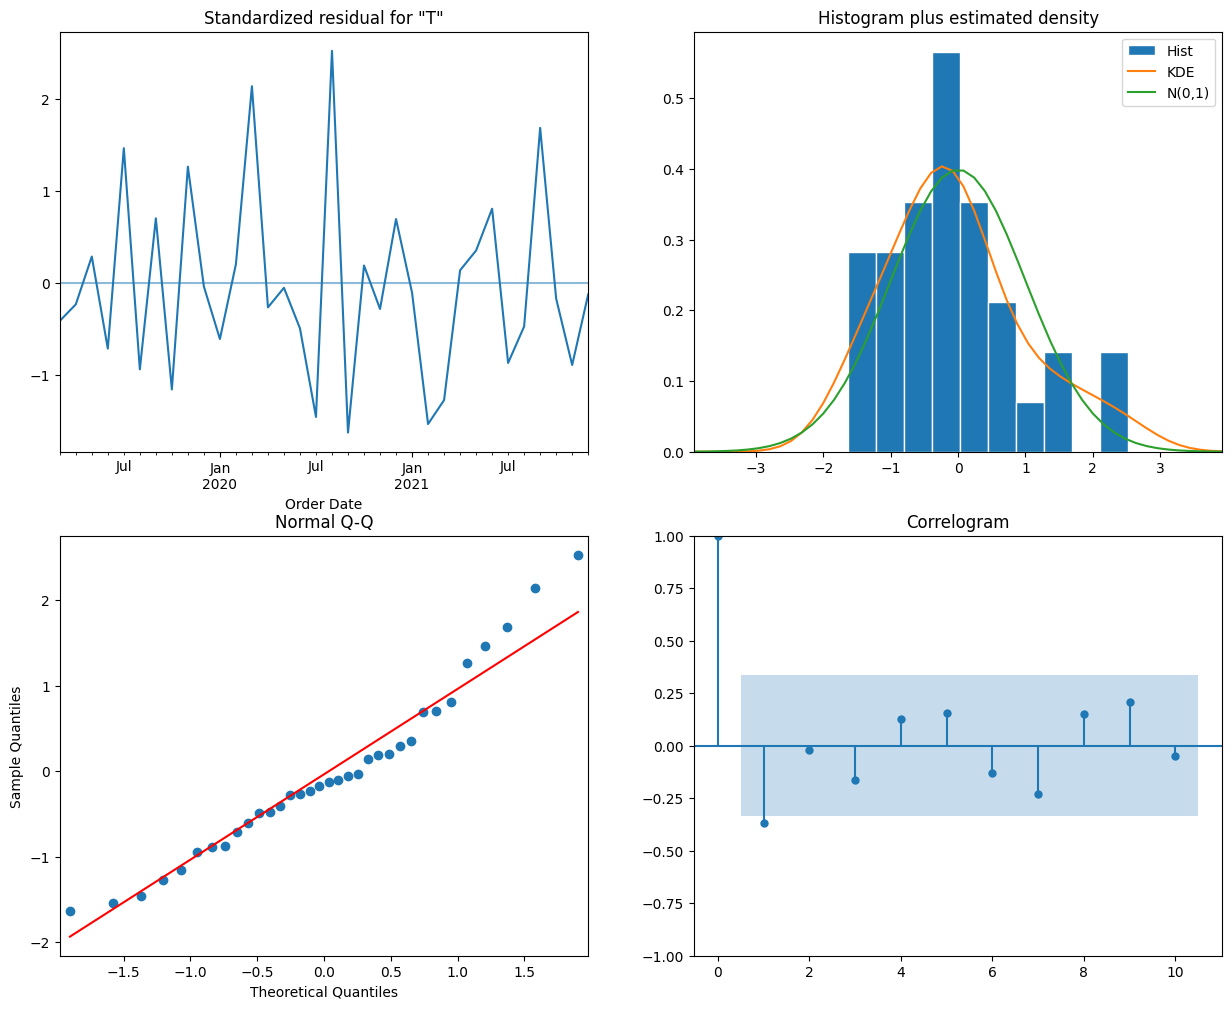

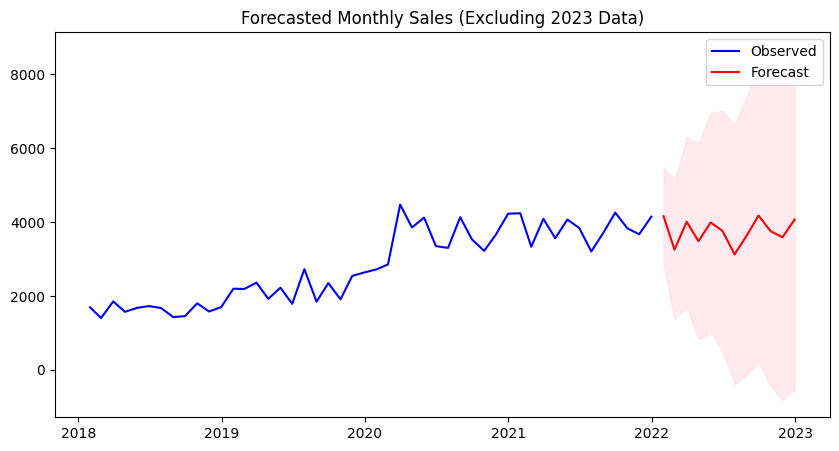

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the filtered dataset
url = 'https://raw.githubusercontent.com/clionmuhoza/Business_Forecasting_Project/refs/heads/main/Filtered_combined_dataset_until_2022.csv'
data = pd.read_csv(url, parse_dates=['Order Date'], index_col='Order Date')

# Calculate total sales
data['Total Sales'] = data['Purchase Price Per Unit'] * data['Quantity']

# Feature Engineering: Adding month and year as separate columns
data['Month'] = data.index.month
data['Year'] = data.index.year

# Create dummy variables for categorical data, such as state and product title
data = pd.get_dummies(data, columns=['Shipping Address State', 'Title'])

# Aggregate the total sales by month
monthly_sales = data['Total Sales'].resample('M').sum()

# Preparing exogenous variables (external factors)
exog_data = data[['Month', 'Year']].resample('M').mean()

# Fit a simplified SARIMAX Model
model = SARIMAX(monthly_sales,
                order=(0, 1, 0),                  # Simplified model
                seasonal_order=(0, 1, 0, 12),     # No AR or MA components seasonally
                exog=exog_data,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Print out the results
print(results.summary())

# Check if it's safe to plot diagnostics
if len(monthly_sales) > 24:  # Arbitrary, ensure sufficient data points for diagnostics
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()

# Forecasting the next 12 months
forecast = results.get_forecast(steps=12, exog=exog_data.iloc[-12:])
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecast results
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales.index, monthly_sales, label='Observed', color='blue')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='red')
plt.fill_between(mean_forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Forecasted Monthly Sales (Excluding 2023 Data)')
plt.show()


<ipython-input-21-352eaf34dd68>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data['Total Sales'].resample('M').sum()


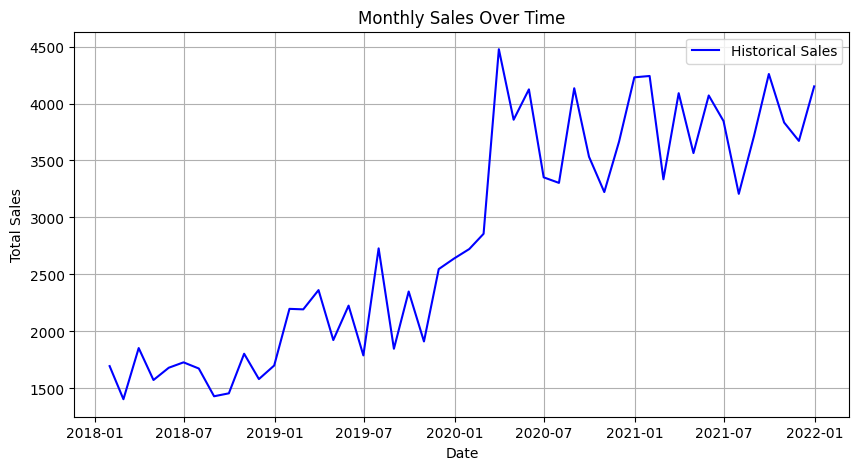

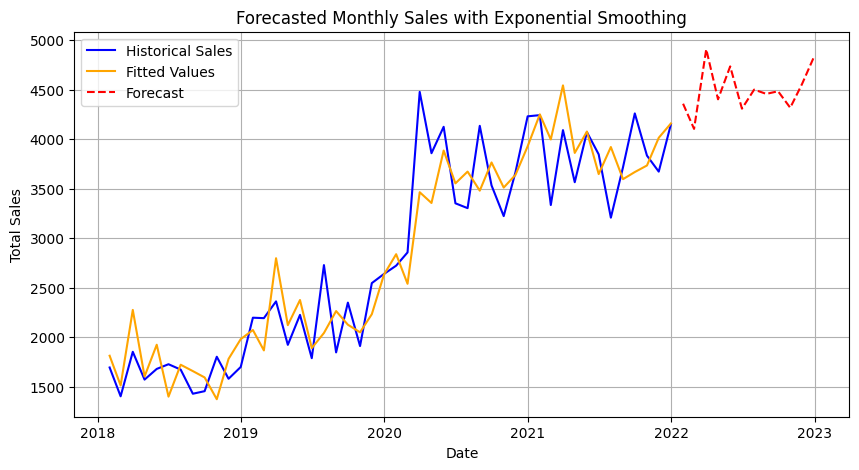

Model Parameters:
{'smoothing_level': 0.389932539381554, 'smoothing_trend': 0.0023058138924243123, 'smoothing_seasonal': 0.003554191436703361, 'damping_trend': nan, 'initial_level': 1587.1605573084219, 'initial_trend': 56.99412816966493, 'initial_seasons': array([ 170.15254687, -140.28860477,  607.5471132 ,   44.61437453,
        320.61560844, -163.90983607,  -26.06224061, -127.57251466,
       -158.73696724, -380.56320614, -197.20316946,   24.18613459]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the dataset
url = 'https://raw.githubusercontent.com/clionmuhoza/Business_Forecasting_Project/refs/heads/main/Filtered_combined_dataset_until_2022.csv'
data = pd.read_csv(url, parse_dates=['Order Date'], index_col='Order Date')

# Calculate Total Sales
data['Total Sales'] = data['Purchase Price Per Unit'] * data['Quantity']

# Aggregate sales data by month
monthly_sales = data['Total Sales'].resample('M').sum()

# Plot the historical data
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales, label='Historical Sales', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid()
plt.show()

# Apply Exponential Smoothing
# Additive trend and seasonality; seasonal_periods=12 for yearly seasonality
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# Forecasting the next 12 months
forecast = fitted_model.forecast(steps=12)

# Plot the historical data, fitted values, and forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales, label='Historical Sales', color='blue')
plt.plot(fitted_model.fittedvalues, label='Fitted Values', color='orange')
plt.plot(forecast, label='Forecast', linestyle='--', color='red')
plt.title('Forecasted Monthly Sales with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid()
plt.show()

# Print model parameters and summary
print("Model Parameters:")
print(fitted_model.params)


<ipython-input-24-9eff8412a036>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data['Total Sales'].resample('M').sum()


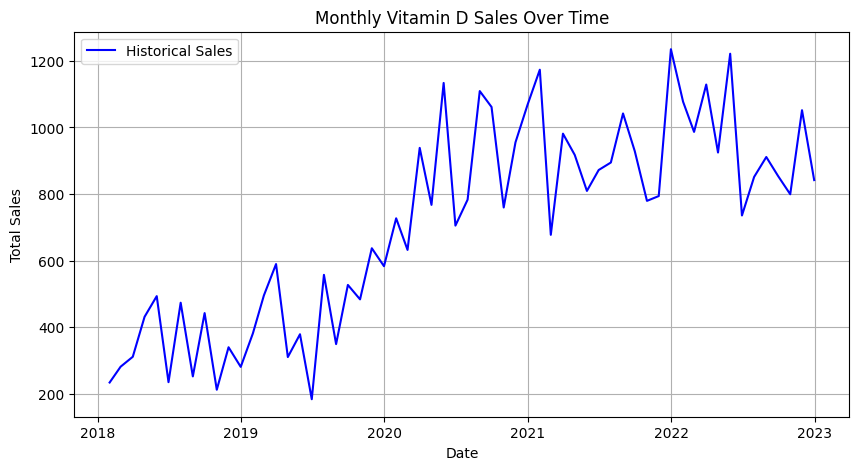

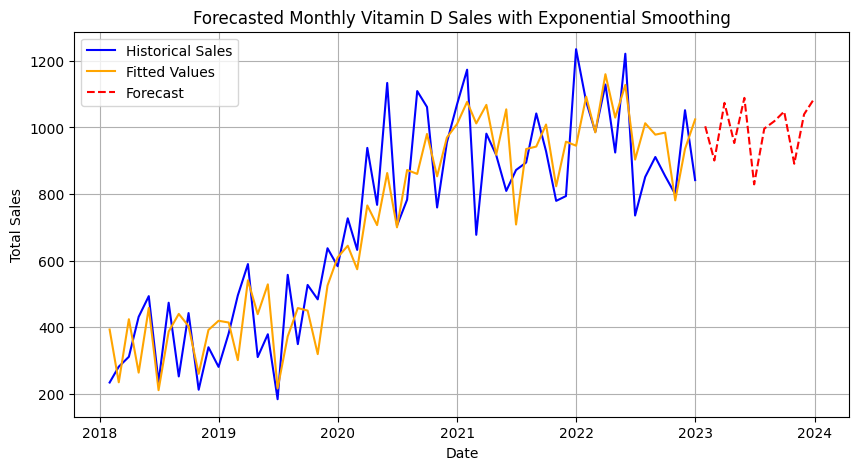

Model Parameters:
{'smoothing_level': 0.3497028945007038, 'smoothing_trend': 0.0037510007518055306, 'smoothing_seasonal': 0.006899563630422024, 'damping_trend': nan, 'initial_level': 318.01986270463465, 'initial_trend': 10.66952564351143, 'initial_seasons': array([  64.77001992,  -48.41896852,  114.05242328,  -17.20253347,
        107.83351058, -162.10890553,   -5.23895464,    6.67812362,
         25.07832639, -142.32706152,   -4.41852657,   30.77734873]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the dataset
url = 'https://raw.githubusercontent.com/clionmuhoza/Business_Forecasting_Project/refs/heads/main/Vitamin_D_dataset_filtered.csv'
data = pd.read_csv(url, parse_dates=['Order Date'], index_col='Order Date')

# Calculate Total Sales
data['Total Sales'] = data['Purchase Price Per Unit'] * data['Quantity']

# Aggregate sales data by month
monthly_sales = data['Total Sales'].resample('M').sum()

# Plot the historical data
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales, label='Historical Sales', color='blue')
plt.title('Monthly Vitamin D Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid()
plt.show()

# Apply Exponential Smoothing
# Additive trend and seasonality; seasonal_periods=12 for yearly seasonality
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# Forecasting the next 12 months
forecast = fitted_model.forecast(steps=12)

# Plot the historical data, fitted values, and forecast
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales, label='Historical Sales', color='blue')
plt.plot(fitted_model.fittedvalues, label='Fitted Values', color='orange')
plt.plot(forecast, label='Forecast', linestyle='--', color='red')
plt.title('Forecasted Monthly Vitamin D Sales with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid()
plt.show()

# Print model parameters and summary
print("Model Parameters:")
print(fitted_model.params)

